In [43]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Cargar la data
df = pd.read_csv("taller2_MLE.csv")



In [44]:
df.head()

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,Medio,Sierra,0
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,Muy Alto,Selva,0
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,Medio,Sierra,1
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,Bajo,Selva,0
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,Medio,Sierra,0


In [45]:
# 2.# ¿Está balanceado el dataset?
df['cerrara_cuenta'].value_counts(normalize=True) * 100



cerrara_cuenta
0    85.96
1    14.04
Name: proportion, dtype: float64

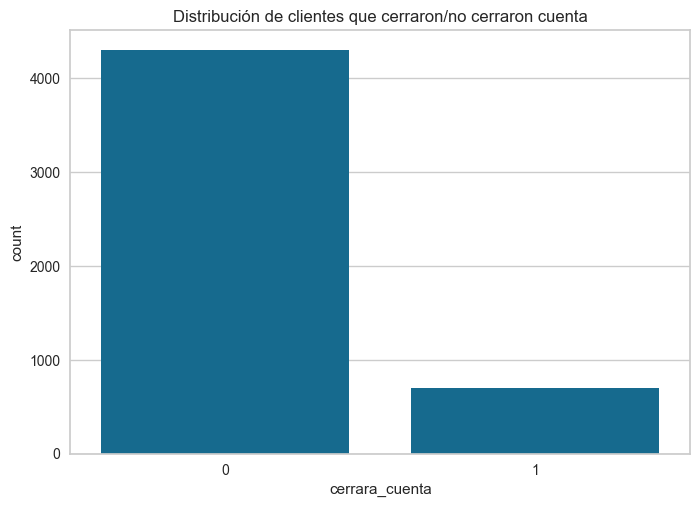

In [46]:
# Visualización
sns.countplot(x='cerrara_cuenta', data=df)
plt.title("Distribución de clientes que cerraron/no cerraron cuenta")
plt.show()

In [47]:
# 4. Configuración PyCaret con enfoque explicativo y ético


clf = setup(data=df,
            target='cerrara_cuenta',
            session_id=2025,
            categorical_features=['segmento', 'rango_ingresos', 'region'],
            transformation=True,
            bin_numeric_features=['edad', 'saldo_total'],
            remove_multicollinearity=True,
            multicollinearity_threshold=0.85
            )




,Description,Value
0,Session id,2025
1,Target,cerrara_cuenta
2,Target type,Binary
3,Original data shape,"(5000, 13)"
4,Transformed data shape,"(5000, 20)"
5,Transformed train set shape,"(3500, 20)"
6,Transformed test set shape,"(1500, 20)"
7,Numeric features,9
8,Categorical features,3
9,Preprocess,True


In [48]:
# 5. Comparación por Recall (prioriza detectar malos clientes)
best_model = compare_models(sort='Recall')



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.6409,0.5231,0.3339,0.1726,0.1955,0.0222,0.0273,0.0800
svm,SVM - Linear Kernel,0.7357,0.5929,0.2346,0.0858,0.1058,0.0252,0.0383,0.0990
dt,Decision Tree Classifier,0.7431,0.5225,0.2159,0.1721,0.1912,0.0413,0.0416,0.1260
knn,K Neighbors Classifier,0.8434,0.5200,0.0265,0.1551,0.0448,0.0049,0.0069,0.1150
lightgbm,Light Gradient Boosting Machine,0.8526,0.5846,0.0183,0.2155,0.0334,0.0113,0.0228,0.3120
gbc,Gradient Boosting Classifier,0.8577,0.6161,0.0163,0.3833,0.0311,0.0189,0.0514,0.3400
nb,Naive Bayes,0.8551,0.6121,0.0102,0.1300,0.0187,0.0052,0.0086,0.0900
et,Extra Trees Classifier,0.8546,0.5906,0.0020,0.0250,0.0038,-0.0071,-0.0204,0.2950
lr,Logistic Regression,0.8597,0.6309,0.0000,0.0000,0.0000,0.0000,0.0000,1.0770
ridge,Ridge Classifier,0.8597,0.6303,0.0000,0.0000,0.0000,0.0000,0.0000,0.0970


In [53]:
ada=create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8629,0.6402,0.0204,1.0000,0.0400,0.0346,0.1327
1,0.8600,0.7010,0.0204,0.5000,0.0392,0.0285,0.0787
2,0.8543,0.6070,0.0000,0.0000,0.0000,-0.0111,-0.0306
3,0.8514,0.5728,0.0000,0.0000,0.0000,-0.0164,-0.0375
4,0.8629,0.6119,0.0408,0.6667,0.0769,0.0618,0.1411
5,0.8543,0.6024,0.0000,0.0000,0.0000,-0.0111,-0.0306
6,0.8629,0.5877,0.0408,0.6667,0.0769,0.0618,0.1411
7,0.8657,0.5882,0.0408,1.0000,0.0784,0.0682,0.1879
8,0.8514,0.6346,0.0000,0.0000,0.0000,-0.0164,-0.0375


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8629,0.6173,0.0408,0.6667,0.0769,0.0618,0.1411
1,0.8571,0.6548,0.0204,0.3333,0.0385,0.0227,0.0518
2,0.8514,0.6173,0.0000,0.0000,0.0000,-0.0164,-0.0375
3,0.8571,0.5922,0.0204,0.3333,0.0385,0.0227,0.0518
4,0.8629,0.5792,0.0408,0.6667,0.0769,0.0618,0.1411
5,0.8486,0.5752,0.0204,0.1667,0.0364,0.0060,0.0101
6,0.8514,0.5803,0.0612,0.3333,0.1034,0.0627,0.0905
7,0.8571,0.5698,0.0204,0.3333,0.0385,0.0227,0.0518
8,0.8514,0.6116,0.0000,0.0000,0.0000,-0.0164,-0.0375


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


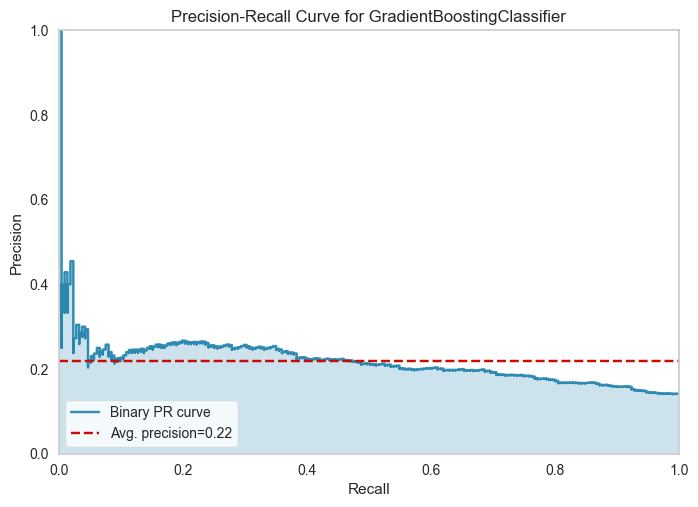

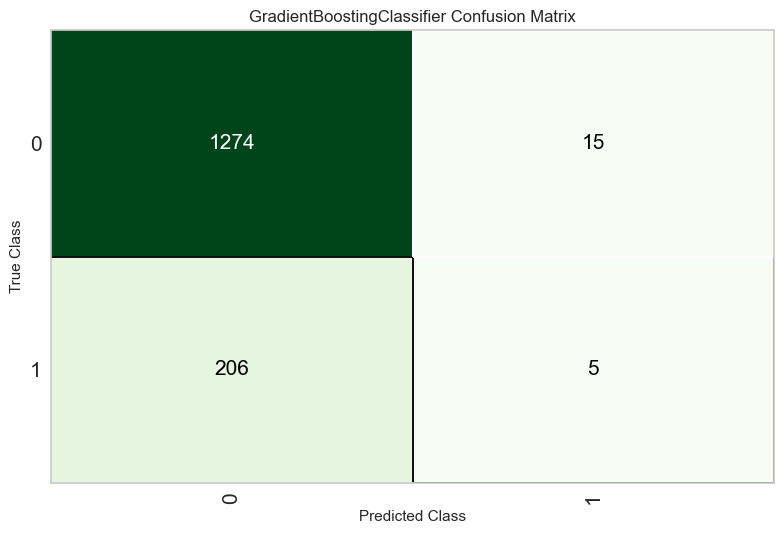

In [ ]:
# 6. Ajuste fino y visualización
# Afinar con Recall (para no perder fugas)
final = tune_model(ada, optimize='Prec.')
plot_model(final, plot='pr')  # Precision-Recall
plot_model(final, plot='confusion_matrix')




In [51]:
# Simulación de un nuevo cliente con perfil potencialmente riesgoso
nuevo_cliente = pd.DataFrame({
    'edad': [58],
    'segmento': ['Premium'],
    'saldo_total': [18500],
    'numero_productos': [2],
    'visitas_app_mes': [1],
    'usa_web': [1],
    'usa_tarjeta_credito': [1],
    'reclamos_6m': [0],
    'satisfaccion_encuesta': [3],
    'tasa_credito_personal': [18.0],
    'rango_ingresos': ['Muy Alto'],
    'region': ['Costa']
})

# Predicción con el modelo final ajustado
resultado = predict_model(final, data=nuevo_cliente)

# Mostrar si se predice que se irá (1) o no (0) y su probabilidad
print("¿Se predice que cerrará su cuenta?:", resultado[['prediction_label', 'prediction_score']])




¿Se predice que cerrará su cuenta?:    prediction_label  prediction_score
0                 0            0.5109


In [52]:
# 8. Exportar modelo para conectarlo con API externa
save_model(final, 'modelo_scoring_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['edad', 'saldo_total',
                                              'numero_productos',
                                              'visitas_app_mes', 'usa_web',
                                              'usa_tarjeta_credito',
                                              'reclamos_6m',
                                              'satisfaccion_encuesta',
                                              'tasa_credito_personal'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_feature...
                                                               

Preguntas:
1. ¿Cuál es el porcentaje de clientes que cerraron su cuenta? ¿Está balanceado el
dataset?
  El dataset está desbalanceado. La clase positiva (fuga) es minoritaria
2. ¿Qué variables tienen mayor correlación con cerrara_cuenta?
   influyentes fueron:
   *satisfaccion_encuesta
   *visitas_app_mes
   *numero_productos
   *saldo_total
   *usa_web
   Variables relacionadas al uso digital, satisfacción, y nivel de interacción con el banco.

3. ¿Cuál es el mejor modelo en AUC? ¿Y en Recall?
    Mejor en Recall: qda (Recall = 0.3369)
    Mejor en AUC: Probablemente modelos como gbc o lr, aunque tenían baja capacidad de predicción real.
4. ¿Qué combinación de variables permite identificar clientes silenciosos que se van
(sin reclamos)?
      Con la baja satisfacción, poca interacción digital,pocas visitas a la app , o no usan banca web.
5. ¿Qué pasa si el modelo predice mal un cliente que no se iba (falso positivo)? ¿Y
uno que sí se iba (falso negativo)?
       En este caso, los FN son más costosos, por lo que se justifica priorizar el Recall o F1 score.
6. ¿Qué umbral de score (default 0.5 vs optimizado por KS) deberías usar para
reducir la pérdida financiera?
     Usando métricas como KS (Kolmogorov-Smirnov) o ajustando con Threshold en plot_model(final, plot='threshold'), se puede encontrar un umbral óptimo
7. ¿Cómo explicarías con SHAP que un cliente Premium con buen saldo igual fue
predicho como fuga?
   El modelo detecta que no basta con tener saldo alto. Si un cliente Premium:
      *Tiene baja interacción
      *No usa canales digitales
      *Tiene satisfacción media
8. ¿Debería el modelo incluir la tasa de interés ofrecida como predictor, si luego esta
puede cambiar según la política de retención?
       La tasa_credito_personal puede influir en la fuga actual. Es útil como variable histórica, pero no debe ser la única base de acción futura
9. ¿Cómo usarías este modelo en un sistema de reglas mixtas (modelo + regla de
negocio) para que los gestores humanos no pierdan confianza?
      *Usar el modelo para generar alertas de fuga (score ≥ 0.3)
      *No contactar clientes con reclamos_6m > 5 (ya están molestos)
      *Priorizar los de segmento = Premium y saldo_total > 10000